# Zunächst wird die Läsionsmaske anhand der Ground Truth berechnet

In [2]:
import os
import sys
import numpy as np

In [3]:
data = np.load('Simulated_Lesion_GT/data.npy')
data_ft =  np.fft.fftshift(np.fft.fft(data, axis=3), axes=3)

In [4]:
# |data| im relevanten Frequenzfenster (Index 95–105)
window = np.abs(data_ft[:, :, :, 95:106, :])

# Maximum über Fenster (axis=3) und Wiederholungen (axis=4)
max_vals = window.max(axis=(3, 4))

# Binäre Maske mit Schwellwert 1
mask = (max_vals > 1.9).astype(np.uint8)  # Shape: (22, 22, 21)

In [5]:
# Nun noch sinnlose x<9 auf 0 setzen
mask[:,:8,...]= 0

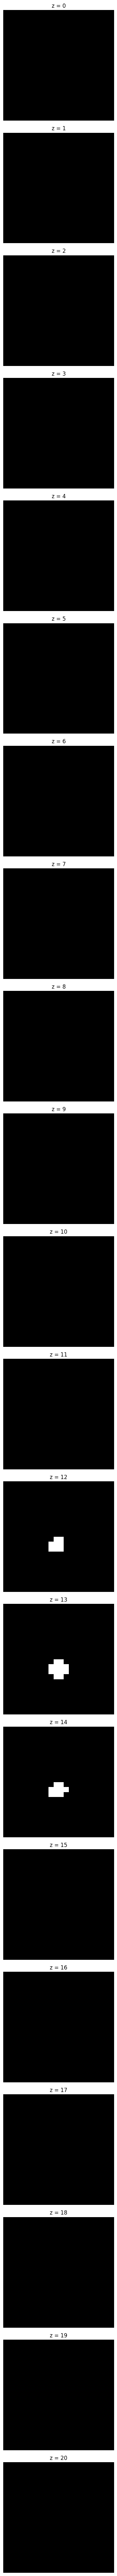

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(21, 1, figsize=(5, 80))  # Breite=5, Höhe=80

for z in range(21):
    ax = axes[z]
    ax.imshow(mask[:, :, z], cmap="gray", origin="lower")
    ax.set_title(f"z = {z}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Als nächstes neue Daten struktur berechnen, die zufällige ground truth Läsions Voxel enthält

In [7]:
# neuen array nu rmit lesion voxel erstellen

import numpy as np

# data: (X,Y,Z,t,T), mask: (X,Y,Z) mit 1 innerhalb der Läsion
X, Y, Z, t, T = data.shape

# Indizes aller Läsions-Voxel
lesion_idx = np.argwhere(mask == 1)
if lesion_idx.size == 0:
    raise ValueError("Maske enthält keine Läsions-Voxel (==1).")

# Für jede räumliche Position einen zufälligen Läsions-Index ziehen (mit Zurücklegen)
sel = np.random.randint(0, len(lesion_idx), size=(X, Y, Z))

# Quellkoordinaten (je (X,Y,Z))
src_x = lesion_idx[sel, 0]
src_y = lesion_idx[sel, 1]
src_z = lesion_idx[sel, 2]

# Zusammenbauen: jedes Zielvoxel bekommt die (t,T)-Daten seines zufällig gewählten Läsionsvoxels
lesion = data[src_x, src_y, src_z, :, :]   # Shape: (X, Y, Z, t, T)
lesion_ft = np.fft.fftshift(np.fft.fft(lesion, axis=3), axes=3)

In [11]:
lesion.shape

(22, 22, 21, 120, 8)

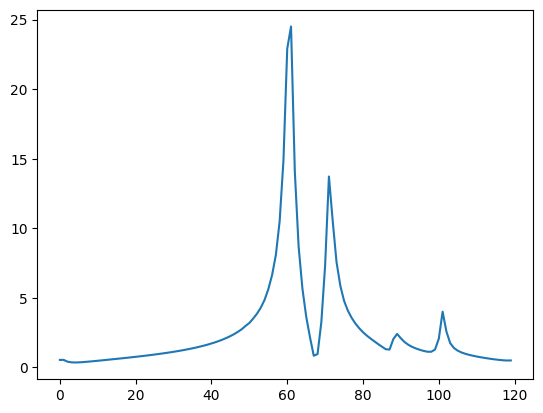

In [9]:
x,y,z,T = 2,10,5,7

Slice = np.abs(lesion_ft)[x,y,z,:,T]

plt.plot(Slice)

# Realistisches Noise berechnen, das auf die ganze Daten Struktur addiert werden kann:
# Vorgehen: Noise im kspace simulieren, hamming filer, in image space transformieren, auf GT addieren!

In [10]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


def hamming_filter(arr, apply_dims, filter_width=100):
    """
    Apply an N‑D outer‑product Hamming filter along the specified axes.

    Parameters
    ----------
    arr : np.ndarray
        Input k‑space array. Wird hier direkt im k‑space gefiltert!
    apply_dims : sequence of int
        Achsen, entlang derer der Filter angewendet wird.
    filter_width : float, optional
        Prozentualer Anteil des Filters (100 = voller Hamming‑Window,
        50 = nur auf die äußeren 50 % angewendet).

    Returns
    -------
    out : np.ndarray
        Gefiltertes Array, gleiche Form wie `arr`.
    """
    out = arr.copy()
    for dim in apply_dims:
        n = arr.shape[dim]
        # Länge des 1D‑Hamming‑Fensters
        fw = int(np.ceil(filter_width/100 * n))
        # Erzeuge das 1D‑Fenster
        win = np.hamming(fw)
        # Links/rechts mit Einsen auffüllen, damit die Mitte unberührt bleibt
        pad_total = n - fw
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        full = np.concatenate([
            np.ones(pad_left, dtype=win.dtype),
            win,
            np.ones(pad_right, dtype=win.dtype)
        ])
        # Für Broadcast auf die korrekte Dimension bringen
        shape = [1] * arr.ndim
        shape[dim] = n
        full = full.reshape(shape)
        # multiplikative Kombination (OuterProduct über alle dims)
        out = out * full
    return out

# Beispielnutzung:
# kspace: dein komplexes k‑space-Array (z.B. nach ifftshift/ifft)
# dims = [0,1,2]  # Hamming auf x,y,z
# kspace_filtered = hamming_filter(kspace, dims, filter_width=100)

In [14]:
Noisesigma = 97.66666666
filter_width = 100
from pathlib import Path


# 4 verschiedene Instanzen erzeugen und speichern
for i in range(1, 5):
    out_dir = Path(f"Only_Lesion_data_{i}")
    out_dir.mkdir(parents=True, exist_ok=True)

    # eigener RNG pro Instanz (reproduzierbar via Seed)
    rng = np.random.default_rng(seed=10_000 + i)

    # --- generate noise (komplexes Gauß-Rauschen) ---
    noise = (rng.standard_normal(lesion.shape) + 1j * rng.standard_normal(lesion.shape)) * Noisesigma
    k_space_noisy = noise

    # --- define hamming filter ---
    kspace_filtered = hamming_filter(k_space_noisy, apply_dims=[0, 1, 2], filter_width=filter_width)

    # --- back to image space ---
    noise_data = np.fft.ifftn(np.fft.ifftshift(kspace_filtered, axes=(0, 1, 2)), axes=(0, 1, 2))

    noise_data = noise_data + lesion

    # Optional: FID-Fourier entlang der -2 Achse (wie in deinem Beispiel)
    noise_data_fft = np.fft.ifftshift(
        np.fft.fft(np.fft.fftshift(noise_data, axes=-2), axis=-2),
        axes=-2
    )

    # Speichern – gewünscht ist noise_data als data.npy
    np.save(out_dir / "data.npy", noise_data)
    # Optional zusätzlich:
    # np.save(out_dir / "data_fft.npy", noise_data_fft)

print("Fertig: Simulated_Lesion_double_1..4 mit jeweils data.npy erstellt.")


Fertig: Simulated_Lesion_double_1..4 mit jeweils data.npy erstellt.


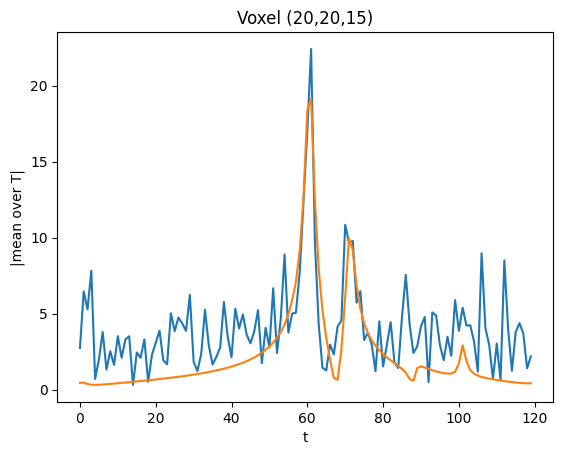

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x, y, z, T = 20, 20, 15, 7

# Mittel über T (noch komplex), dann Betrag
slice_avg = np.abs(noise_data_fft[x, y, z, :, T])

Slice_2 = np.abs(lesion_ft)[x,y,z,:,T]

plt.plot(slice_avg)
plt.plot(Slice_2)
plt.xlabel("t")
plt.ylabel("|mean over T|")
plt.title(f"Voxel ({x},{y},{z})")
plt.show()


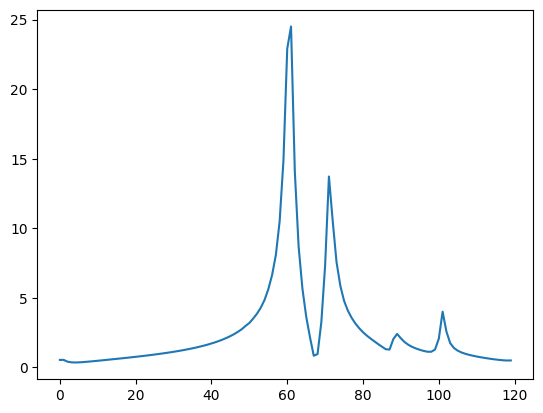

In [25]:
x,y,z,T = 2,10,5,7

Slice = np.abs(lesion_ft)[x,y,z,:,T]

plt.plot(Slice)